<a href="https://colab.research.google.com/github/racaga12/basic-prediction-sp500-with-LSMT/blob/main/basic_prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# 1. Cargar datos
data = pd.read_csv('SP500.csv', parse_dates=['observation_date'], index_col='observation_date')
data = data.dropna()
prices = data['SP500'].values

# 2. Normalizar datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices.reshape(-1, 1))

In [ ]:
# 3. Crear secuencias
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_prices, seq_length)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# 4. Construir el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 5. Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0220 - val_loss: 4.3724e-04
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0013 - val_loss: 6.1890e-04
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0013 - val_loss: 5.7783e-04
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0012 - val_loss: 4.3554e-04
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 9.8574e-04 - val_loss: 0.0019
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 9.0838e-04 - val_loss: 9.6555e-04
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━

In [ ]:
# 6. Predecir y evaluar
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


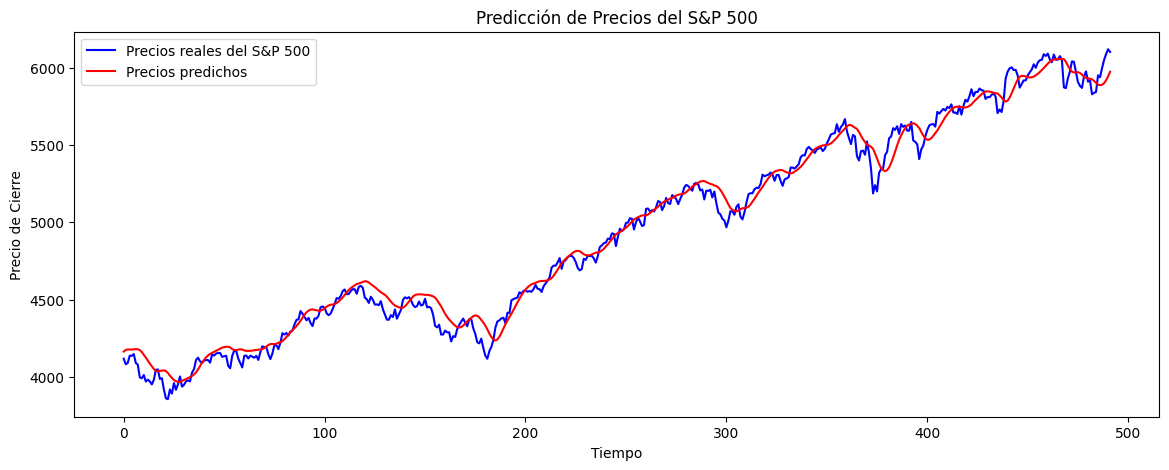

In [ ]:
# 7. Visualizar resultados
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color='blue', label='Precios reales del S&P 500')
plt.plot(predicted_prices, color='red', label='Precios predichos')
plt.title('Predicción de Precios del S&P 500')
plt.xlabel('Tiempo')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

In [ ]:
# 8. Evaluar el modelo
mse = mean_squared_error(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)
print(f'Error Cuadrático Medio (MSE): {mse}')
print(f'Error Absoluto Medio (MAE): {mae}')

Error Cuadrático Medio (MSE): 5755.120337944727
Error Absoluto Medio (MAE): 58.47373904344514


In [ ]:
# 9. Predecir los próximos 180 días
last_sequence = scaled_prices[-seq_length:].reshape(1, seq_length, 1)
predicted_prices = []

for _ in range(180):
    # Predecir el próximo día
    next_day_price = model.predict(last_sequence)

    # Guardar la predicción
    predicted_prices.append(next_day_price[0, 0])

    # Reformatear next_day_price para que tenga la forma (1, 1, 1)
    next_day_price_reshaped = next_day_price.reshape(1, 1, 1)

    # Actualizar la secuencia para incluir la predicción
    last_sequence = np.append(last_sequence[:, 1:, :], next_day_price_reshaped, axis=1)

# Convertir las predicciones a la escala original
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

# 10. Generar fechas futuras
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=180)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━

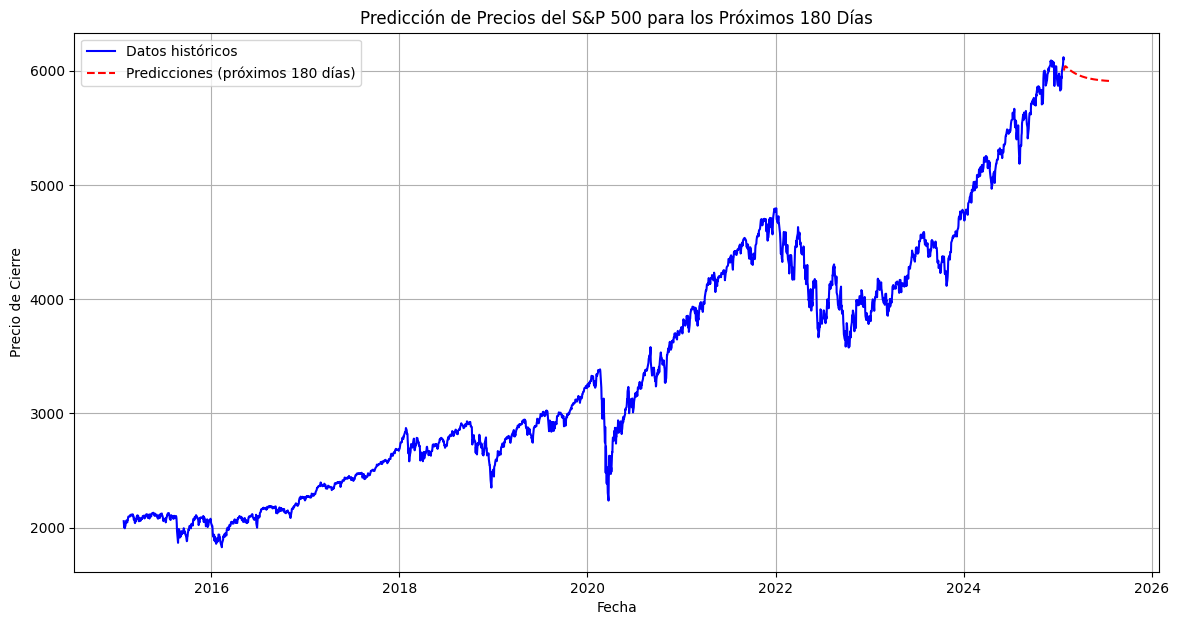

In [ ]:
# 11. Visualizar las predicciones
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['SP500'], label='Datos históricos', color='blue')
plt.plot(future_dates, predicted_prices, label='Predicciones (próximos 180 días)', color='red', linestyle='--')
plt.title('Predicción de Precios del S&P 500 para los Próximos 180 Días')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.grid(True)
plt.show()